# インポート

In [1]:
import re
from tqdm import tqdm
import time

import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen

import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
ss = preprocessing.StandardScaler()

import warnings
warnings.simplefilter('ignore')

In [2]:
# url = "https://db.netkeiba.com/race/"
# keibajou = {'01':'札幌', '02':'函館', '03':'福島', '04':'新潟', '05':'東京', '06':'中山', '07':'中京', '08':'京都', '09':'阪神', '10':'小倉'}

# 関数の定義

In [3]:
'''スクレイピング'''
# メインテーブルのスクレイピング
def scrape_netkeiba_results(year, course='全部', pre_race_results={}):
    
    #URLの番号部分１２桁の作成
    race_course = {'札幌': 1, '函館': 2, '福島': 3, '新潟': 4, '東京': 5, '中山': 6, '中京': 7, '京都': 8, '阪神': 9, '小倉': 10, '全部': 11}
    place = race_course[course]
    race_id_list = []
    #馬場の指定
    if place != 11:
        for kai in range(1, 7, 1):
            for y in year:
                for day in range(1, 13, 1):
                    for r in range(1, 13, 1):
                        race_id = str(y) + str(place).zfill(2) + str(kai).zfill(2) + str(day).zfill(2) + str(r).zfill(2)
                        race_id_list.append(race_id)
    else:
        for place in range(1, 11, 1):
            for kai in range(1, 7, 1):
                for y in year:
                    for day in range(1, 13, 1):
                        for r in range(1, 13, 1):
                            race_id = str(y) + str(place).zfill(2) + str(kai).zfill(2) + str(day).zfill(2) + str(r).zfill(2)
                            race_id_list.append(race_id)
    #スクレイピング開始                    
    race_results = pre_race_results.copy()
    for race_id in tqdm(race_id_list):
        if race_id in race_results.keys():
            continue
        try:
            url = 'https://db.netkeiba.com/race/' + race_id
            df = pd.read_html(url)[0]
            #horse_id,jockey_idをスクレイピング
            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')
            horse_id_list = []
            horse_a_list = soup.find(
                'table', attrs = {'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/horse')})
            for a in horse_a_list:
                horse_id = re.findall(r'\d+', a['href'])
                horse_id_list.append(horse_id[0])
            jockey_id_list = []
            jockey_a_list = soup.find(
                'table', attrs = {'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/jockey')})
            for a in jockey_a_list:
                jockey_id = re.findall(r'\d+', a['href'])
                jockey_id_list.append(jockey_id[0])    
            
            df['horse_id'] = horse_id_list
            df['jockey_id'] = jockey_id_list
            race_results[race_id] = df
            time.sleep(1)
        except IndexError:
            continue
        except:
            break
    #dataframeに整形
    for key in race_results:
        race_results[key].index = [key] * len(race_results[key])
    results = pd.concat([race_results[key] for key in race_results], sort=False)
    
    now = datetime.now()
    file_name = "{0:%Y%m%d_%H%M%S}.pickle".format(now)
    results.to_pickle(file_name)
    return results
# 天気や馬場状態や日付を取得する
def scrape_race_info(race_id_list):
    race_infos = {}
    for race_id in tqdm(race_id_list):
        try:
            url = "https://db.netkeiba.com/race/" + str(race_id)
            html = requests.get(url)
            html.encoding = "EUC-JP"
            soup = BeautifulSoup(html.text, "html.parser")
            texts = soup.find_all('p')[3].text + soup.find_all("p")[4].text
            info = re.findall(r"\w+", texts)

            info_dict = {}
            for text in info:
                if text in ["芝", "ダート"]:
                    info_dict["race_type"] = text
                if "障" in text:
                    info_dict["race_type"] = "障害"
                if "m" in text:
                    info_dict["course_len"] = int(re.findall(r"\d+", text)[0])
                if text in ["良", "稍重", "重", "不良"]:
                    info_dict["ground_state"] = text
                if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                    info_dict["weather"] = text
                if "年" in text:
                    info_dict["date"] = text
                if '歳' in text:
                    info_dict['race_name'] = text

            race_infos[race_id] = info_dict
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return race_infos
# 馬ごとの過去のレース結果情報をスクレイピング
def scrape_horse_results(horse_id_list):
    #horse_idをkeyにしてDataFrame型を格納
    horse_results = {}
    for horse_id in tqdm(horse_id_list):
        try:
            url = 'https://db.netkeiba.com/horse/' + horse_id
            df = pd.read_html(url)[3]
	    #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
            if df.columns[0]=='受賞歴':
                df = pd.read_html(url)[4]
            horse_results[horse_id] = df
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    
    return horse_results
# 払い戻し情報をスクレイピング
def scrape_return_tables(race_id_list, pre_return_tables={}):
    return_tables = pre_return_tables
    for race_id in tqdm(race_id_list):
        try:
            url = "https://db.netkeiba.com/race/" + race_id
            
            #普通にスクレイピングすると複勝やワイドなどが区切られないで繋がってしまう。
            #そのため、改行コードを文字列brに変換して後でsplitする
            f = urlopen(url)
            html = f.read()
            html = html.replace(b'<br />', b'br')
            dfs = pd.read_html(html)

            #dfsの1番目に単勝〜馬連、2番目にワイド〜三連単がある
            df = pd.concat([dfs[1], dfs[2]])

            df.index = [race_id] * len(df)
            return_tables[race_id] = df
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e: #捕捉できるエラーは原因がわかるようにprintしてからbreak
            print(e)
            break
        except:
            break
    return return_tables
# 血統データをスクレイピング
def scrape_peds(horse_id_list, pre_peds={}):
    peds = pre_peds
    for horse_id in tqdm(horse_id_list):
        try:
            url = 'https://db.netkeiba.com/horse/ped/' + horse_id
            df = pd.read_html(url)[0]

            generations = {}
            for i in reversed(range(5)):
                generations[i] = df[i]
                df.drop([i], axis=1, inplace=True)
                df = df.drop_duplicates()
            ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
            peds[horse_id] = ped.reset_index(drop=True)
            time.sleep(1)
        except IndexError:
            continue
        except Exception as e:
            print(e)
            break
        except:
            break
    return peds

'''データクレンジング'''
def pre_main(results):
    df = results.copy()

    df['race_id'] = df.index
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)

    df = df[~(df['着順'].astype(str).str.contains('\D'))]
    df['着順'] = df['着順'].astype(int)

    df['性'] = df['性齢'].map(lambda x: str(x)[0])
    df = pd.get_dummies(data=df, columns=['性'], drop_first=True)
    df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)
    df['体重'] = df['馬体重'].str.split('(', expand=True)[0].astype(int)
    df['増減'] = df['馬体重'].str.split('(', expand=True)[1].str[:-1].astype(int)
    df['単勝'] = df['単勝'].astype(float)
    
    df['rank'] = df['着順'].map(lambda x: 1 if x<4 else 0)
    df.drop(['タイム', '着差', '性齢', '馬体重', '着順', '馬名', '騎手', '調教師', '人気', '単勝'], axis=1, inplace=True)
    return df

def pre_info(infos):
    df = infos.copy()

    df['course_len'] = df['course_len'].astype(int)
    df['race_id'] = df.index
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
    df = pd.get_dummies(data=df, columns=['weather', 'race_type', 'ground_state', 'race_name'], drop_first=True)

    return df

def pre_horse(horse_results):
    '''整形'''
    # 日付について
    df = horse_results.copy()
    df['date'] = pd.to_datetime(df['日付'])
    df.drop(columns=['日付'], inplace=True)
    # 着順について
    df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
    df.dropna(subset=['着順'], inplace=True)
    df['着順'] = df['着順'].astype(int)
    df['rank_rate'] = df['着順'] / df['頭数']
    # 距離について
    df['コース'] = df['距離'].map(lambda x: str(x)[0])
    df['距離'] = df['距離'].map(lambda x: int(str(x)[1:]))
    # 賞金について
    df['賞金'].fillna(0, inplace=True)
    # 出走数について
    df['cource_counts'] = int(1)
    
    '''抽出'''
    # 馬ごとの賞金合計
    df_horse_results = pd.DataFrame(df.groupby('horse_id')['賞金', 'cource_counts'].sum())
    df_horse_results = pd.merge(df_horse_results, pd.DataFrame(df.groupby('horse_id')['rank_rate'].mean()), on='horse_id', how='outer')

    # 阪神競馬場の賞金合計
    df_horse_han = df[df['開催'].astype(str).str.contains('阪神')]
    sum_han = pd.DataFrame(df_horse_han.groupby('horse_id')['賞金', 'cource_counts'].sum())
    mean_han = pd.DataFrame(df_horse_han.groupby('horse_id')['rank_rate'].mean())
    df_horse_results = pd.merge(df_horse_results, sum_han, on='horse_id', how='outer')
    df_horse_results = pd.merge(df_horse_results, mean_han, on='horse_id', how='outer')

    # 距離の賞金合計
    # スプリント:1400未満
    df_horse_splint = df[df['距離']<1400]
    sum_splint = pd.DataFrame(df_horse_splint.groupby('horse_id')['賞金', 'cource_counts'].sum())
    mean_splint = pd.DataFrame(df_horse_splint.groupby('horse_id')['rank_rate'].mean())
    df_horse_results = pd.merge(df_horse_results, sum_splint, on='horse_id', how='outer')
    df_horse_results = pd.merge(df_horse_results, mean_splint, on='horse_id', how='outer')

    # マイル:1800未満
    df_horse_mile = df[(df['距離']<1800) & (df['距離']>=1400)]
    sum_mile = pd.DataFrame(df_horse_mile.groupby('horse_id')['賞金', 'cource_counts'].sum())
    mean_mile = pd.DataFrame(df_horse_mile.groupby('horse_id')['rank_rate'].mean())
    df_horse_results = pd.merge(df_horse_results, sum_mile, on='horse_id', how='outer')
    df_horse_results = pd.merge(df_horse_results, mean_mile, on='horse_id', how='outer')

    # クラシック:2400未満
    df_horse_classic = df[(df['距離']>=1800) & (df['距離']<2400)]
    sum_classic = pd.DataFrame(df_horse_classic.groupby('horse_id')['賞金', 'cource_counts'].sum())
    mean_classic = pd.DataFrame(df_horse_classic.groupby('horse_id')['rank_rate'].mean())
    df_horse_results = pd.merge(df_horse_results, sum_classic, on='horse_id', how='outer')
    df_horse_results = pd.merge(df_horse_results, mean_classic, on='horse_id', how='outer')

    # ステイヤー:2400以上
    df_horse_stayer = df[df['距離']>=2400]
    sum_stayer = pd.DataFrame(df_horse_stayer.groupby('horse_id')['賞金', 'cource_counts'].sum())
    mean_stayer = pd.DataFrame(df_horse_stayer.groupby('horse_id')['rank_rate'].mean())
    df_horse_results = pd.merge(df_horse_results, sum_stayer, on='horse_id', how='outer')
    df_horse_results = pd.merge(df_horse_results, mean_stayer, on='horse_id', how='outer')

    # コースの種類別賞金合計
    # 芝
    df_horse_turf = df[df['コース']=='芝']
    sum_turf = pd.DataFrame(df_horse_turf.groupby('horse_id')['賞金', 'cource_counts'].sum())
    mean_turf = pd.DataFrame(df_horse_turf.groupby('horse_id')['rank_rate'].mean())
    df_horse_results = pd.merge(df_horse_results, sum_turf, on='horse_id', how='outer')
    df_horse_results = pd.merge(df_horse_results, mean_turf, on='horse_id', how='outer')

    # ダート
    df_horse_dirt = df[df['コース']=='ダ']
    sum_dirt = pd.DataFrame(df_horse_dirt.groupby('horse_id')['賞金', 'cource_counts'].sum())
    mean_dirt = pd.DataFrame(df_horse_dirt.groupby('horse_id')['rank_rate'].mean())
    df_horse_results = pd.merge(df_horse_results, sum_dirt, on='horse_id', how='outer')
    df_horse_results = pd.merge(df_horse_results, mean_dirt, on='horse_id', how='outer')

    # 今後の実装　馬場情報の追加

    '''カラム名の設定'''
    df_horse_results.columns = [
        'ALLprize', 'ALLcounts', 'ALLrank',
        'HANSHINprize', 'HANSHINcounts', 'HANSHINrank',
        'SPLINTprize', 'SPLINTcounts', 'SPLINTrank',
        'MILEprize', 'MILEcounts', 'MILErank',
        'CLASSICprize', 'CLASSICcounts', 'CLASSICrank',
        'STAYERprize', 'STAYERcounts', 'STAYERrank',
        'TURFprize', 'TURFcounts', 'TURFrank',
        'DIRTprize', 'DIRTcounts', 'DIRTrank',
    ]
    
    df_horse_results.reset_index(inplace=True)
    df_horse_results.fillna(0, inplace=True)

    return df_horse_results

class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables

    @property
    def fukusho(self):
        fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1, 2]]
        wins = fukusho[1].str.split('br', expand=True)[[0, 1, 2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        returns = fukusho[2].str.split('br', expand=True)[[0, 1, 2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        df = pd.concat([wins, returns], axis=1)
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
        return df.fillna(0).astype(int)
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0]=='単勝'][[1, 2]]
        tansho.columns = ['win', 'return']
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
        return tansho

def calculate_fukusho_return(df_y, fukusho, threshold=0.5):
    pred_table = df_y.copy()[['race_id', '馬番', 'pred']]
    fukusho_table = fukusho.copy()
    pred_table['pred_threshold'] = pred_table['pred'].map(lambda x: 1 if x > threshold else 0)
    pred_bet_table = pred_table[pred_table['pred_threshold']==1]
    money = -100 * len(pred_bet_table)
    fukusho_table.reset_index(inplace=True)
    fukusho_table.columns = ['race_id', 'win_0', 'win_1', 'win_2', 'return_0', 'return_1', 'return_2']
    df_calculate = pd.merge(pred_bet_table, fukusho_table, on='race_id', how='left')
    for i in range(3):
        money += df_calculate[df_calculate['win_{}'.format(i)]==df_calculate['馬番']]['return_{}'.format(i)].sum()
    return money

# スクレイピングによるデータ収集

In [4]:
# 10年分のmainデータをスクレイピング
# year = [y for y in range(2012, 2022)]
# results = scrape_netkeiba_results(year=year, course='阪神')

# df = pd.read_pickle('2012-2021hanshin.pickle')
# df['race_id'] = df.index
# df.reset_index(inplace=True)
# df.drop(columns='index', inplace=True)

# race_id_list = list(df.race_id.unique())
# horse_id_list = list(df.horse_id.unique())
# print(len(horse_id_list))
# print(len(race_id_list))

In [5]:
# 天気などの情報をスクレイピング
# dict_info = scrape_race_info(race_id_list)

# df_info = pd.DataFrame(dict_info).T
# df_info.to_pickle('df_info.pickle')

In [6]:
# 払い戻し情報をスクレイピング
# dict_return = scrape_return_tables(race_id_list)

# dict_returnをデータフレーム型に変換しpickleファイルで保存
# df_return = pd.DataFrame()
# for i in tqdm(dict_return.keys()):
#     dict_return[i]['race_id'] = i
#     df_return = pd.concat([df_return, dict_return[i]])

# df_return.to_pickle('df_return.pickle')

# データクレンジング

In [10]:
# データの読み込み
df = pd.read_pickle('2012-2021hanshin.pickle')
df_info = pd.read_pickle('df_info.pickle')
df_horse = pd.read_pickle('df_horse_alldata.pickle')

In [11]:
# データの前処理
df = pre_main(df)
df_info = pre_info(df_info)
df = pd.merge(df, df_info, on='race_id', how='left')
df = pd.merge(df, df_horse, on='horse_id', how='left')
df.jockey_id = df.jockey_id.astype('int')
df.sort_values(by=['race_id', '馬番'], inplace=True)

In [12]:
select_columns = ['枠番', '馬番', '斤量', 'jockey_id', '年齢', '体重', '増減', 
       'course_len', 'weather_小雪', 'weather_晴', 'weather_曇', 'weather_雨', 'race_type_芝', 'race_type_障害',
       'ground_state_稍重', 'ground_state_良', 'ground_state_重',
       # 'race_name_2歳500万下', 'race_name_2歳オープン', 'race_name_2歳新馬',
       # 'race_name_2歳未勝利', 'race_name_3歳1勝クラス', 'race_name_3歳500万下',
       # 'race_name_3歳オープン', 'race_name_3歳以上1000万下', 'race_name_3歳以上1600万下',
       # 'race_name_3歳以上1勝クラス', 'race_name_3歳以上2勝クラス', 'race_name_3歳以上3勝クラス',
       # 'race_name_3歳以上500万下', 'race_name_3歳以上オープン', 'race_name_3歳新馬',
       # 'race_name_3歳未勝利', 'race_name_4歳以上1000万下', 'race_name_4歳以上1600万下',
       # 'race_name_4歳以上1勝クラス', 'race_name_4歳以上2勝クラス', 'race_name_4歳以上3勝クラス',
       # 'race_name_4歳以上500万下', 'race_name_4歳以上オープン', 'race_name_障害3歳以上オープン',
       # 'race_name_障害3歳以上未勝利', 'race_name_障害4歳以上オープン', 'race_name_障害4歳以上未勝利',
       'ALLprize', 'ALLcounts', 'ALLrank', 'HANSHINprize', 'HANSHINcounts',
       'HANSHINrank', 'SPLINTprize', 'SPLINTcounts', 'SPLINTrank', 'MILEprize',
       'MILEcounts', 'MILErank', 'CLASSICprize', 'CLASSICcounts',
       'CLASSICrank', 'STAYERprize', 'STAYERcounts', 'STAYERrank', 'TURFprize',
       'TURFcounts', 'TURFrank', 'DIRTprize', 'DIRTcounts', 'DIRTrank'
       ]

In [13]:
# データ分割
train, test = df[df.date.dt.strftime('%Y')!='2021'], df[df.date.dt.strftime('%Y')=='2021']
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

train_x, train_t, test_x, test_t = train[select_columns], train['rank'], test[select_columns], test['rank']

ss.fit(train_x)
train_x_ = ss.transform(train_x)
test_x_ = ss.transform(test_x)

# モデル構築 

In [14]:
# DeepLearning用の設定
# train_x_ = train_x.values
train_t_ = train_t.values
# test_x_ = test_x.values
test_t_ = test_t.values
train_t_ = train_t_.reshape(-1, 1)
test_t_ = test_t_.reshape(-1, 1)

print(f'train_x info:{train_x_.shape}, {type(train_x_)}')
print(f'train_t info:{train_t_.shape}, {type(train_t_)}')
print(f'test_x info:{test_x_.shape}, {type(test_x_)}')
print(f'test_t info:{test_t_.shape}, {type(test_t_)}')

train_x info:(85500, 41), <class 'numpy.ndarray'>
train_t info:(85500, 1), <class 'numpy.ndarray'>
test_x info:(15887, 41), <class 'numpy.ndarray'>
test_t info:(15887, 1), <class 'numpy.ndarray'>


In [15]:
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    c = np.max(x, axis=-1, keepdims=True)
    exp_a = np.exp(x-c)
    sum_exp_a = np.sum(exp_a, axis=-1, keepdims=True)
    y = exp_a / sum_exp_a
    return y

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
    batch_size = y.shape[0]
    return np.sum((-t * np.log(y + 1e-7)) - ((1-t) * np.log(1-y + 1e-7))) / batch_size

def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = tmp_val + h
        fxh1 = f()
        x[idx] = tmp_val - h
        fxh2 = f()
        grad[idx] = (fxh1 - fxh2) / (2 * h)
        x[idx] = tmp_val
        it.iternext()
    return grad

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        return dx

class Relu:
    def __init__(self):
        self.mask = None
    
    def forward(self, x):
        self.mask = (x <= 0 )
        out = x.copy()
        out[self.mask] = 0
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout
        return dx

class SigmoidWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.t = None
    
    def forward(self, x, t):
        self.t = t
        self.y = sigmoid(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss
    
    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) * (dout / batch_size)
        return dx

In [18]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        # Heの初期値
        self.params['W1'] = 2 * np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
        self.params['b1'] = np.zeros(hidden_size)
        # Xavierの初期値
        self.params['W2'] = np.random.randn(hidden_size, output_size) / np.sqrt(input_size)
        self.params['b2'] = np.zeros(output_size)

        self.layers = {}
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SigmoidWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x)
        loss = self.lastLayer.forward(y, t)
        return loss
    
    def accuracy(self, x, t, threshold=0.3):
        y = self.predict(x)
        y_ = sigmoid(y)
        if y_.all() > threshold:
            y__ = np.array([[1]])
        else:
            y__ = np.array([[0]])
        accuracy = np.sum(y__ == t) / x.shape[0]
        return accuracy

    def numerical_gradient(self, x, t):
        grads = {}
        grads['W1'] = numerical_gradient(lambda: self.loss(x, t), self.params['W1'])
        grads['b1'] = numerical_gradient(lambda: self.loss(x, t), self.params['b1'])
        grads['W2'] = numerical_gradient(lambda: self.loss(x, t), self.params['W2'])
        grads['b2'] = numerical_gradient(lambda: self.loss(x, t), self.params['b2'])
        return grads

    def gradient(self, x, t):
        self.loss(x, t)
        dout = self.lastLayer.backward()
        for layer in reversed(list(self.layers.values())):
            dout = layer.backward(dout)
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        return grads

In [19]:
network = TwoLayerNet(input_size=train_x_.shape[1], hidden_size=512, output_size=1)
x_batch = train_x_[:3]
t_batch = train_t_[:3]
grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
    print(key + ':' + str(diff))

W1:1.2276256970122628e-06
b1:5.577095022567348e-07
W2:6.731490993067966e-06
b2:7.748636334681258e-06


In [20]:
iters_num = 30000
batch_size = 300
learning_rate = 0.01
threshold = 0.25
train_loss_list = []
train_acc_list = []
test_acc_list = []
train_df = pd.DataFrame()
test_df = pd.DataFrame()

train_size = train_x_.shape[0]
iter_per_epoch = max(int(train_size/batch_size), 1)

network = TwoLayerNet(input_size=train_x_.shape[1], hidden_size=512, output_size=1)
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size, replace=False)
    x_batch = train_x_[batch_mask]
    t_batch = train_t_[batch_mask]

    grad = network.gradient(x_batch, t_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_pred = network.predict(x_batch)
        train_pred_ = sigmoid(train_pred)

        train_df['pred'] = train_pred_.T[0]
        train_df['true'] = t_batch.T[0]
        train_df['pred_thre'] = train_df['pred'].map(lambda x: 1 if x>=threshold else 0)
        train_acc = accuracy_score(train_df['true'], train_df['pred_thre'])
        train_acc_list.append(train_acc)

        test_pred = network.predict(test_x_)
        test_pred_ = sigmoid(test_pred)
        test_df['pred'] = test_pred_.T[0]
        test_df['true'] = test_t_.T[0]
        test_df['pred_thre'] = test_df['pred'].map(lambda x: 1 if x>=threshold else 0)
        test_acc = accuracy_score(test_df['true'], test_df['pred_thre'])
        test_acc_list.append(test_acc)
        print(f'[更新数]{i:>4} [損失関数の値]{loss:.4f} '
              f'[訓練データの認識精度]{train_acc:.4f} [テストデータの認識精度]{test_acc:.4f}')

[更新数]   0 [損失関数の値]1.6227 [訓練データの認識精度]0.4833 [テストデータの認識精度]0.5092
[更新数] 285 [損失関数の値]0.5230 [訓練データの認識精度]0.7167 [テストデータの認識精度]0.7297
[更新数] 570 [損失関数の値]0.5104 [訓練データの認識精度]0.7033 [テストデータの認識精度]0.7409
[更新数] 855 [損失関数の値]0.4332 [訓練データの認識精度]0.7767 [テストデータの認識精度]0.7478
[更新数]1140 [損失関数の値]0.4237 [訓練データの認識精度]0.7500 [テストデータの認識精度]0.7417
[更新数]1425 [損失関数の値]0.4102 [訓練データの認識精度]0.7667 [テストデータの認識精度]0.7458
[更新数]1710 [損失関数の値]0.4090 [訓練データの認識精度]0.7633 [テストデータの認識精度]0.7513
[更新数]1995 [損失関数の値]0.4180 [訓練データの認識精度]0.7367 [テストデータの認識精度]0.7480
[更新数]2280 [損失関数の値]0.4385 [訓練データの認識精度]0.7133 [テストデータの認識精度]0.7685
[更新数]2565 [損失関数の値]0.3744 [訓練データの認識精度]0.7700 [テストデータの認識精度]0.7534
[更新数]2850 [損失関数の値]0.3504 [訓練データの認識精度]0.7833 [テストデータの認識精度]0.7603
[更新数]3135 [損失関数の値]0.4290 [訓練データの認識精度]0.7567 [テストデータの認識精度]0.7467
[更新数]3420 [損失関数の値]0.3782 [訓練データの認識精度]0.7867 [テストデータの認識精度]0.7438
[更新数]3705 [損失関数の値]0.3994 [訓練データの認識精度]0.7933 [テストデータの認識精度]0.7609
[更新数]3990 [損失関数の値]0.3837 [訓練データの認識精度]0.7533 [テストデータの認識精度]0.7789
[更新数]4275 [損失関数の値]0.4272 [訓練データの認識精度]0.7

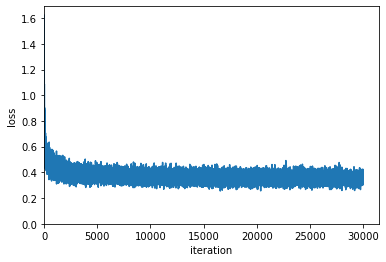

In [21]:
x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list, label='loss')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.show()

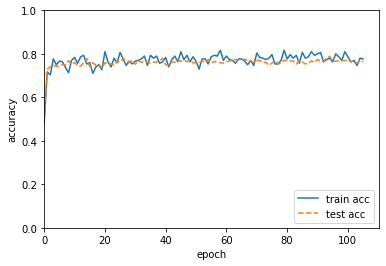

In [22]:
x2 = np.arange(len(train_acc_list))
plt.plot(x2, train_acc_list, label='train acc')
plt.plot(x2, test_acc_list, label='test acc', linestyle='--')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim(left=0)
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()